# CNN-LSTM Hybrid for Decoding EEG

In this notebook, we will explore how a Resnet-LSTM performs on EEG data, which has both spatial and temporal components.

In [1]:
from resnetLSTMv2 import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch import Tensor
from typing import Type
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import random

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


In [14]:
# Load training data
X_train_valid = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/X_train_valid.npy")
y_train_valid = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/y_train_valid.npy")
y_train_valid = y_train_valid - 769
person_train_valid = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/person_train_valid.npy")

# Load test data
x_test = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/X_test.npy")
y_test = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/y_test.npy")
y_test = y_test - 769
person_test = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/person_test.npy")

# Print shapes
print('X train: ', X_train_valid.shape)
print('y train: ', y_train_valid.shape)
print('Person train+valid: ', person_train_valid.shape)
print('X test: ', x_test.shape)
print('y test: ', y_test.shape)
print('Person test: ', person_test.shape)

X train:  (2115, 22, 1000)
y train:  (2115,)
Person train+valid:  (2115, 1)
X test:  (443, 22, 1000)
y test:  (443,)
Person test:  (443, 1)


## Part 1: Training and validating on raw EEG data

In [4]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

#Convert to tensors
x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of training set: torch.Size([1692, 22, 1000])
Shape of validation set: torch.Size([423, 22, 1000])
Shape of training labels: (1692,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([1692, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torch.Size([1692, 22, 1000, 1])
Shape of validation set after adding width info: torch.Size([423, 22, 1000, 1])
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: torch.Size([1692, 1, 22, 1000])
Shape of validation set after dimension reshaping: torch.Size([423, 1, 22, 1000])
Shape of test set after dimension reshaping: torch.Size([443, 1, 22, 1000])


In [5]:
#Test random sample function
bsz = 10
x_train_sample, y_train_sample = sample(x_train, y_train, bsz)
print(len(x_train_sample), len(y_train_sample))

10 10


Build model 1 for training on raw EEG dataset

In [6]:
print(x_train.size(3))
model1 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=1000, dropout=0.6).to(device)
print(model1)
total_params = sum(p.numel() for p in model1.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

1000


c:\Users\awong\anaconda3\envs\c147proj\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

In [7]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)

In [8]:
# Training Time!

train_history_1, val_history_1 = np.array([]), np.array([])
train_loss_hist_1, val_loss_hist_1 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model1.state_dict(), best_model_params_path)
    best_acc = 0.0
    bsz = 100
    num_epochs = 50
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        model1.train()
        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            logits = model1(train_x) #bszx4x1x4
            
            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())
        

        train_acc = train_correct_count / train_count

        model1.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            logits = model1(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        train_history_1 = np.append(train_history_1, train_acc.item())
        val_history_1 = np.append(val_history_1, val_acc.item())
        train_loss_hist_1 = np.append(train_loss_hist_1, loss.item())
        val_loss_hist_1 = np.append(val_loss_hist_1, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model1.state_dict(), best_model_params_path)
    
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model1.load_state_dict(torch.load(best_model_params_path))

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\awong\AppData\Local\Temp\ipykernel_26776\76442630.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  2%|▏         | 1/50 [04:42<3:50:32, 282.29s/it]

Epoch 1 Finished!!!
Train acc: 0.270, Val acc: 0.246
Train loss: 1.386, Val loss: 1.386
Epoch 2 Finished!!!


  4%|▍         | 2/50 [05:03<1:42:51, 128.56s/it]

Train acc: 0.200, Val acc: 0.255
Train loss: 1.394, Val loss: 1.385
Epoch 3 Finished!!!


  6%|▌         | 3/50 [05:23<1:02:08, 79.33s/it] 

Train acc: 0.340, Val acc: 0.248
Train loss: 1.379, Val loss: 1.387
Epoch 4 Finished!!!


  8%|▊         | 4/50 [05:44<43:09, 56.28s/it]  

Train acc: 0.300, Val acc: 0.274
Train loss: 1.374, Val loss: 1.379
Epoch 5 Finished!!!


 10%|█         | 5/50 [06:05<32:34, 43.44s/it]

Train acc: 0.320, Val acc: 0.293
Train loss: 1.369, Val loss: 1.377
Epoch 6 Finished!!!


 12%|█▏        | 6/50 [06:26<26:17, 35.85s/it]

Train acc: 0.330, Val acc: 0.291
Train loss: 1.366, Val loss: 1.375
Epoch 7 Finished!!!


 14%|█▍        | 7/50 [06:47<22:05, 30.82s/it]

Train acc: 0.350, Val acc: 0.319
Train loss: 1.360, Val loss: 1.370
Epoch 8 Finished!!!


 16%|█▌        | 8/50 [07:07<19:14, 27.50s/it]

Train acc: 0.430, Val acc: 0.336
Train loss: 1.342, Val loss: 1.362
Epoch 9 Finished!!!


 18%|█▊        | 9/50 [07:27<17:16, 25.28s/it]

Train acc: 0.390, Val acc: 0.333
Train loss: 1.353, Val loss: 1.357
Epoch 10 Finished!!!


 20%|██        | 10/50 [07:48<15:53, 23.84s/it]

Train acc: 0.400, Val acc: 0.362
Train loss: 1.324, Val loss: 1.349
Epoch 11 Finished!!!


 22%|██▏       | 11/50 [08:08<14:48, 22.78s/it]

Train acc: 0.420, Val acc: 0.348
Train loss: 1.324, Val loss: 1.351
Epoch 12 Finished!!!


 24%|██▍       | 12/50 [08:29<14:00, 22.13s/it]

Train acc: 0.500, Val acc: 0.371
Train loss: 1.290, Val loss: 1.344
Epoch 13 Finished!!!


 26%|██▌       | 13/50 [08:50<13:24, 21.74s/it]

Train acc: 0.370, Val acc: 0.369
Train loss: 1.318, Val loss: 1.344
Epoch 14 Finished!!!


 28%|██▊       | 14/50 [09:11<12:53, 21.49s/it]

Train acc: 0.380, Val acc: 0.404
Train loss: 1.312, Val loss: 1.325
Epoch 15 Finished!!!


 30%|███       | 15/50 [09:32<12:26, 21.34s/it]

Train acc: 0.410, Val acc: 0.416
Train loss: 1.310, Val loss: 1.321
Epoch 16 Finished!!!


 32%|███▏      | 16/50 [09:53<12:00, 21.21s/it]

Train acc: 0.470, Val acc: 0.392
Train loss: 1.268, Val loss: 1.327
Epoch 17 Finished!!!


 34%|███▍      | 17/50 [10:14<11:38, 21.17s/it]

Train acc: 0.480, Val acc: 0.392
Train loss: 1.257, Val loss: 1.322
Epoch 18 Finished!!!


 36%|███▌      | 18/50 [10:35<11:15, 21.12s/it]

Train acc: 0.450, Val acc: 0.437
Train loss: 1.283, Val loss: 1.304
Epoch 19 Finished!!!


 38%|███▊      | 19/50 [10:56<10:53, 21.07s/it]

Train acc: 0.520, Val acc: 0.421
Train loss: 1.265, Val loss: 1.307
Epoch 20 Finished!!!


 40%|████      | 20/50 [11:17<10:31, 21.05s/it]

Train acc: 0.470, Val acc: 0.418
Train loss: 1.284, Val loss: 1.303
Epoch 21 Finished!!!


 42%|████▏     | 21/50 [11:38<10:07, 20.96s/it]

Train acc: 0.500, Val acc: 0.388
Train loss: 1.264, Val loss: 1.318
Epoch 22 Finished!!!


 44%|████▍     | 22/50 [11:58<09:46, 20.94s/it]

Train acc: 0.460, Val acc: 0.428
Train loss: 1.254, Val loss: 1.298
Epoch 23 Finished!!!


 46%|████▌     | 23/50 [12:19<09:25, 20.96s/it]

Train acc: 0.490, Val acc: 0.397
Train loss: 1.262, Val loss: 1.302
Epoch 24 Finished!!!


 48%|████▊     | 24/50 [12:41<09:06, 21.01s/it]

Train acc: 0.470, Val acc: 0.402
Train loss: 1.278, Val loss: 1.303
Epoch 25 Finished!!!


 50%|█████     | 25/50 [13:02<08:45, 21.02s/it]

Train acc: 0.570, Val acc: 0.418
Train loss: 1.218, Val loss: 1.297
Epoch 26 Finished!!!


 52%|█████▏    | 26/50 [13:22<08:22, 20.93s/it]

Train acc: 0.500, Val acc: 0.433
Train loss: 1.252, Val loss: 1.293
Epoch 27 Finished!!!


 54%|█████▍    | 27/50 [13:43<07:59, 20.86s/it]

Train acc: 0.550, Val acc: 0.407
Train loss: 1.195, Val loss: 1.305
Epoch 28 Finished!!!


 56%|█████▌    | 28/50 [14:04<07:36, 20.76s/it]

Train acc: 0.570, Val acc: 0.430
Train loss: 1.184, Val loss: 1.283
Epoch 29 Finished!!!


 58%|█████▊    | 29/50 [14:24<07:13, 20.66s/it]

Train acc: 0.570, Val acc: 0.456
Train loss: 1.185, Val loss: 1.273
Epoch 30 Finished!!!


 60%|██████    | 30/50 [14:45<06:52, 20.63s/it]

Train acc: 0.570, Val acc: 0.442
Train loss: 1.205, Val loss: 1.285
Epoch 31 Finished!!!


 62%|██████▏   | 31/50 [15:05<06:31, 20.60s/it]

Train acc: 0.530, Val acc: 0.409
Train loss: 1.218, Val loss: 1.300
Epoch 32 Finished!!!


 64%|██████▍   | 32/50 [15:26<06:09, 20.55s/it]

Train acc: 0.560, Val acc: 0.440
Train loss: 1.183, Val loss: 1.299
Epoch 33 Finished!!!


 66%|██████▌   | 33/50 [15:46<05:49, 20.55s/it]

Train acc: 0.540, Val acc: 0.421
Train loss: 1.216, Val loss: 1.284
Epoch 34 Finished!!!


 68%|██████▊   | 34/50 [16:07<05:28, 20.51s/it]

Train acc: 0.610, Val acc: 0.418
Train loss: 1.180, Val loss: 1.295
Epoch 35 Finished!!!


 70%|███████   | 35/50 [16:27<05:08, 20.55s/it]

Train acc: 0.510, Val acc: 0.395
Train loss: 1.245, Val loss: 1.324
Epoch 36 Finished!!!


 72%|███████▏  | 36/50 [16:48<04:47, 20.54s/it]

Train acc: 0.630, Val acc: 0.430
Train loss: 1.130, Val loss: 1.288
Epoch 37 Finished!!!


 74%|███████▍  | 37/50 [17:08<04:26, 20.52s/it]

Train acc: 0.510, Val acc: 0.435
Train loss: 1.231, Val loss: 1.288
Epoch 38 Finished!!!


 76%|███████▌  | 38/50 [17:29<04:06, 20.55s/it]

Train acc: 0.500, Val acc: 0.409
Train loss: 1.242, Val loss: 1.313
Epoch 39 Finished!!!


 78%|███████▊  | 39/50 [17:49<03:46, 20.55s/it]

Train acc: 0.590, Val acc: 0.435
Train loss: 1.168, Val loss: 1.283
Epoch 40 Finished!!!


 80%|████████  | 40/50 [18:10<03:25, 20.57s/it]

Train acc: 0.630, Val acc: 0.440
Train loss: 1.135, Val loss: 1.281
Epoch 41 Finished!!!


 82%|████████▏ | 41/50 [18:31<03:05, 20.61s/it]

Train acc: 0.480, Val acc: 0.449
Train loss: 1.220, Val loss: 1.277
Epoch 42 Finished!!!


 84%|████████▍ | 42/50 [18:52<02:46, 20.80s/it]

Train acc: 0.580, Val acc: 0.449
Train loss: 1.190, Val loss: 1.276
Epoch 43 Finished!!!


 86%|████████▌ | 43/50 [19:13<02:26, 20.95s/it]

Train acc: 0.530, Val acc: 0.400
Train loss: 1.198, Val loss: 1.303
Epoch 44 Finished!!!


 88%|████████▊ | 44/50 [19:34<02:06, 21.01s/it]

Train acc: 0.660, Val acc: 0.433
Train loss: 1.118, Val loss: 1.287
Epoch 45 Finished!!!


 90%|█████████ | 45/50 [19:55<01:44, 20.96s/it]

Train acc: 0.600, Val acc: 0.442
Train loss: 1.145, Val loss: 1.283
Epoch 46 Finished!!!


 92%|█████████▏| 46/50 [20:16<01:23, 20.92s/it]

Train acc: 0.660, Val acc: 0.418
Train loss: 1.116, Val loss: 1.289
Epoch 47 Finished!!!


 94%|█████████▍| 47/50 [20:37<01:02, 20.87s/it]

Train acc: 0.550, Val acc: 0.423
Train loss: 1.194, Val loss: 1.290
Epoch 48 Finished!!!


 96%|█████████▌| 48/50 [20:57<00:41, 20.82s/it]

Train acc: 0.620, Val acc: 0.423
Train loss: 1.116, Val loss: 1.288
Epoch 49 Finished!!!


 98%|█████████▊| 49/50 [21:18<00:20, 20.77s/it]

Train acc: 0.580, Val acc: 0.421
Train loss: 1.150, Val loss: 1.282
Epoch 50 Finished!!!


100%|██████████| 50/50 [21:39<00:00, 25.99s/it]

Train acc: 0.630, Val acc: 0.433
Train loss: 1.123, Val loss: 1.287
Best val Acc: 0.456265


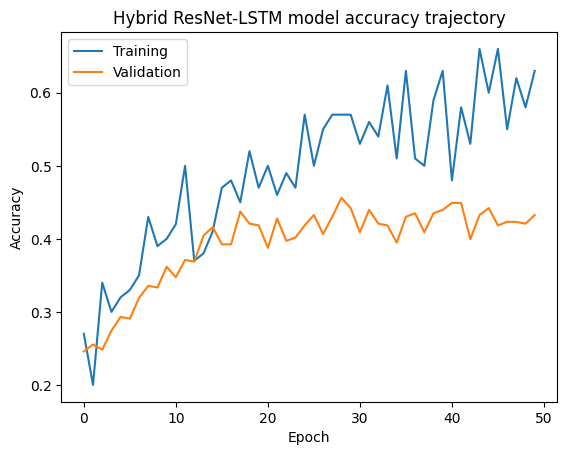

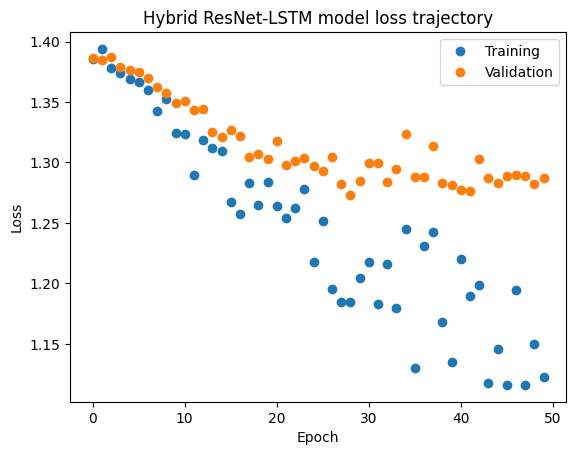

In [11]:
plt.plot(np.arange(num_epochs),train_history_1,label='Training')
plt.plot(np.arange(num_epochs),val_history_1,label='Validation')
plt.title('Hybrid ResNet-LSTM model accuracy trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_1,'o',label='Training')
plt.plot(np.arange(num_epochs),val_loss_hist_1,'o',label='Validation')
plt.title('Hybrid ResNet-LSTM model loss trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 2: Training and validating on preprocessed EEG data

In [15]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset, may need to reload data at top
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid) 

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

Build the model

In [17]:
model2 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model2)
total_params = sum(p.numel() for p in model2.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

c:\Users\awong\anaconda3\envs\c147proj\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

In [18]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-4)

In [19]:
train_history_2, val_history_2 = np.array([]), np.array([])
train_loss_hist_2, val_loss_hist_2 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model2.state_dict(), best_model_params_path)
    best_acc = 0.0
    bsz = 100
    num_epochs = 50
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        model2.train()
        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            logits = model2(train_x) #bszx4x1x4
            
            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())
        

        train_acc = train_correct_count / train_count

        model2.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            logits = model2(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        train_history_2 = np.append(train_history_2, train_acc.item())
        val_history_2 = np.append(val_history_2, val_acc.item())
        train_loss_hist_2 = np.append(train_loss_hist_2, loss.item())
        val_loss_hist_2 = np.append(val_loss_hist_2, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model2.state_dict(), best_model_params_path)
    
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model2.load_state_dict(torch.load(best_model_params_path))

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\awong\AppData\Local\Temp\ipykernel_26776\2221464829.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  2%|▏         | 1/50 [00:30<24:43, 30.27s/it]

Epoch 1 Finished!!!
Train acc: 0.300, Val acc: 0.331
Train loss: 1.379, Val loss: 1.368
Epoch 2 Finished!!!


  4%|▍         | 2/50 [00:57<22:46, 28.47s/it]

Train acc: 0.370, Val acc: 0.397
Train loss: 1.330, Val loss: 1.322
Epoch 3 Finished!!!


  6%|▌         | 3/50 [01:25<22:09, 28.29s/it]

Train acc: 0.440, Val acc: 0.402
Train loss: 1.310, Val loss: 1.314
Epoch 4 Finished!!!


  8%|▊         | 4/50 [01:54<21:44, 28.36s/it]

Train acc: 0.540, Val acc: 0.459
Train loss: 1.272, Val loss: 1.287
Epoch 5 Finished!!!


 10%|█         | 5/50 [02:22<21:16, 28.36s/it]

Train acc: 0.380, Val acc: 0.461
Train loss: 1.314, Val loss: 1.275
Epoch 6 Finished!!!


 12%|█▏        | 6/50 [02:50<20:49, 28.40s/it]

Train acc: 0.540, Val acc: 0.442
Train loss: 1.245, Val loss: 1.278
Epoch 7 Finished!!!


 14%|█▍        | 7/50 [03:19<20:27, 28.54s/it]

Train acc: 0.510, Val acc: 0.478
Train loss: 1.231, Val loss: 1.261
Epoch 8 Finished!!!


 16%|█▌        | 8/50 [03:48<20:02, 28.62s/it]

Train acc: 0.510, Val acc: 0.470
Train loss: 1.234, Val loss: 1.258
Epoch 9 Finished!!!


 18%|█▊        | 9/50 [04:17<19:37, 28.73s/it]

Train acc: 0.600, Val acc: 0.480
Train loss: 1.180, Val loss: 1.250
Epoch 10 Finished!!!


 20%|██        | 10/50 [04:46<19:13, 28.83s/it]

Train acc: 0.510, Val acc: 0.468
Train loss: 1.234, Val loss: 1.259
Epoch 11 Finished!!!


 22%|██▏       | 11/50 [05:15<18:46, 28.90s/it]

Train acc: 0.560, Val acc: 0.494
Train loss: 1.182, Val loss: 1.244
Epoch 12 Finished!!!


 24%|██▍       | 12/50 [05:44<18:15, 28.84s/it]

Train acc: 0.560, Val acc: 0.489
Train loss: 1.207, Val loss: 1.238
Epoch 13 Finished!!!


 26%|██▌       | 13/50 [06:12<17:44, 28.78s/it]

Train acc: 0.620, Val acc: 0.463
Train loss: 1.142, Val loss: 1.263
Epoch 14 Finished!!!


 28%|██▊       | 14/50 [06:41<17:16, 28.80s/it]

Train acc: 0.590, Val acc: 0.485
Train loss: 1.171, Val loss: 1.245
Epoch 15 Finished!!!


 30%|███       | 15/50 [07:10<16:47, 28.78s/it]

Train acc: 0.580, Val acc: 0.489
Train loss: 1.167, Val loss: 1.236
Epoch 16 Finished!!!


 32%|███▏      | 16/50 [07:39<16:16, 28.71s/it]

Train acc: 0.540, Val acc: 0.489
Train loss: 1.196, Val loss: 1.232
Epoch 17 Finished!!!


 34%|███▍      | 17/50 [08:02<14:59, 27.26s/it]

Train acc: 0.740, Val acc: 0.478
Train loss: 1.073, Val loss: 1.249
Epoch 18 Finished!!!


 36%|███▌      | 18/50 [08:26<13:52, 26.01s/it]

Train acc: 0.640, Val acc: 0.480
Train loss: 1.113, Val loss: 1.250
Epoch 19 Finished!!!


 38%|███▊      | 19/50 [08:49<12:59, 25.13s/it]

Train acc: 0.600, Val acc: 0.482
Train loss: 1.171, Val loss: 1.231
Epoch 20 Finished!!!


 40%|████      | 20/50 [09:12<12:15, 24.52s/it]

Train acc: 0.560, Val acc: 0.489
Train loss: 1.168, Val loss: 1.221
Epoch 21 Finished!!!


 42%|████▏     | 21/50 [09:35<11:39, 24.11s/it]

Train acc: 0.620, Val acc: 0.522
Train loss: 1.144, Val loss: 1.219
Epoch 22 Finished!!!


 44%|████▍     | 22/50 [09:58<11:07, 23.84s/it]

Train acc: 0.600, Val acc: 0.534
Train loss: 1.146, Val loss: 1.203
Epoch 23 Finished!!!


 46%|████▌     | 23/50 [10:21<10:38, 23.64s/it]

Train acc: 0.620, Val acc: 0.534
Train loss: 1.134, Val loss: 1.208
Epoch 24 Finished!!!


 48%|████▊     | 24/50 [10:44<10:11, 23.51s/it]

Train acc: 0.670, Val acc: 0.506
Train loss: 1.094, Val loss: 1.234
Epoch 25 Finished!!!


 50%|█████     | 25/50 [11:08<09:45, 23.40s/it]

Train acc: 0.730, Val acc: 0.527
Train loss: 1.031, Val loss: 1.212
Epoch 26 Finished!!!


 52%|█████▏    | 26/50 [11:31<09:19, 23.33s/it]

Train acc: 0.650, Val acc: 0.520
Train loss: 1.098, Val loss: 1.222
Epoch 27 Finished!!!


 54%|█████▍    | 27/50 [11:54<08:55, 23.29s/it]

Train acc: 0.600, Val acc: 0.485
Train loss: 1.130, Val loss: 1.234
Epoch 28 Finished!!!


 56%|█████▌    | 28/50 [12:17<08:31, 23.26s/it]

Train acc: 0.700, Val acc: 0.515
Train loss: 1.048, Val loss: 1.214
Epoch 29 Finished!!!


 58%|█████▊    | 29/50 [12:40<08:07, 23.24s/it]

Train acc: 0.680, Val acc: 0.506
Train loss: 1.073, Val loss: 1.224
Epoch 30 Finished!!!


 60%|██████    | 30/50 [13:04<07:44, 23.23s/it]

Train acc: 0.690, Val acc: 0.501
Train loss: 1.065, Val loss: 1.226
Epoch 31 Finished!!!


 62%|██████▏   | 31/50 [13:27<07:21, 23.22s/it]

Train acc: 0.680, Val acc: 0.489
Train loss: 1.070, Val loss: 1.233
Epoch 32 Finished!!!


 64%|██████▍   | 32/50 [13:50<06:57, 23.21s/it]

Train acc: 0.660, Val acc: 0.527
Train loss: 1.083, Val loss: 1.213
Epoch 33 Finished!!!


 66%|██████▌   | 33/50 [14:13<06:34, 23.20s/it]

Train acc: 0.660, Val acc: 0.518
Train loss: 1.073, Val loss: 1.215
Epoch 34 Finished!!!


 68%|██████▊   | 34/50 [14:37<06:12, 23.29s/it]

Train acc: 0.710, Val acc: 0.537
Train loss: 1.044, Val loss: 1.201
Epoch 35 Finished!!!


 70%|███████   | 35/50 [15:00<05:50, 23.34s/it]

Train acc: 0.800, Val acc: 0.525
Train loss: 0.964, Val loss: 1.208
Epoch 36 Finished!!!


 72%|███████▏  | 36/50 [15:23<05:26, 23.35s/it]

Train acc: 0.730, Val acc: 0.515
Train loss: 1.017, Val loss: 1.209
Epoch 37 Finished!!!


 74%|███████▍  | 37/50 [15:47<05:03, 23.36s/it]

Train acc: 0.710, Val acc: 0.508
Train loss: 1.047, Val loss: 1.213
Epoch 38 Finished!!!


 76%|███████▌  | 38/50 [16:10<04:40, 23.35s/it]

Train acc: 0.690, Val acc: 0.548
Train loss: 1.047, Val loss: 1.190
Epoch 39 Finished!!!


 78%|███████▊  | 39/50 [16:33<04:16, 23.32s/it]

Train acc: 0.650, Val acc: 0.525
Train loss: 1.094, Val loss: 1.206
Epoch 40 Finished!!!


 80%|████████  | 40/50 [16:57<03:53, 23.33s/it]

Train acc: 0.780, Val acc: 0.518
Train loss: 0.997, Val loss: 1.212
Epoch 41 Finished!!!


 82%|████████▏ | 41/50 [17:20<03:30, 23.35s/it]

Train acc: 0.810, Val acc: 0.541
Train loss: 0.960, Val loss: 1.191
Epoch 42 Finished!!!


 84%|████████▍ | 42/50 [17:43<03:06, 23.35s/it]

Train acc: 0.790, Val acc: 0.537
Train loss: 0.979, Val loss: 1.192
Epoch 43 Finished!!!


 86%|████████▌ | 43/50 [18:07<02:43, 23.38s/it]

Train acc: 0.830, Val acc: 0.548
Train loss: 0.935, Val loss: 1.188
Epoch 44 Finished!!!


 88%|████████▊ | 44/50 [18:30<02:20, 23.37s/it]

Train acc: 0.770, Val acc: 0.518
Train loss: 0.979, Val loss: 1.201
Epoch 45 Finished!!!


 90%|█████████ | 45/50 [18:54<01:56, 23.35s/it]

Train acc: 0.780, Val acc: 0.553
Train loss: 0.983, Val loss: 1.189
Epoch 46 Finished!!!


 92%|█████████▏| 46/50 [19:17<01:33, 23.33s/it]

Train acc: 0.830, Val acc: 0.560
Train loss: 0.925, Val loss: 1.185
Epoch 47 Finished!!!


 94%|█████████▍| 47/50 [19:40<01:09, 23.32s/it]

Train acc: 0.830, Val acc: 0.548
Train loss: 0.945, Val loss: 1.192
Epoch 48 Finished!!!


 96%|█████████▌| 48/50 [20:03<00:46, 23.32s/it]

Train acc: 0.760, Val acc: 0.553
Train loss: 0.990, Val loss: 1.180
Epoch 49 Finished!!!


 98%|█████████▊| 49/50 [20:27<00:23, 23.34s/it]

Train acc: 0.770, Val acc: 0.556
Train loss: 0.971, Val loss: 1.190
Epoch 50 Finished!!!


100%|██████████| 50/50 [20:50<00:00, 25.02s/it]

Train acc: 0.800, Val acc: 0.532
Train loss: 0.976, Val loss: 1.193
Best val Acc: 0.560284


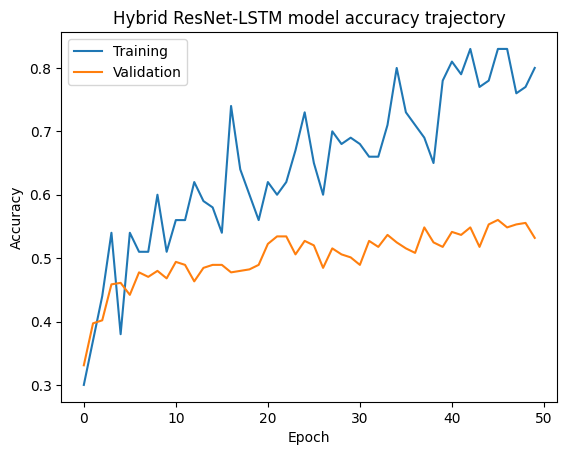

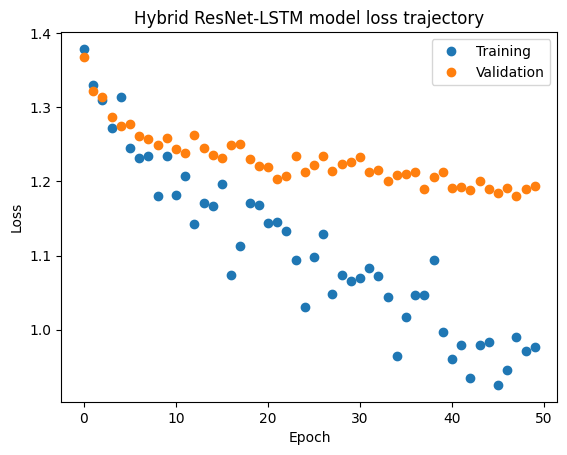

In [20]:
plt.plot(np.arange(num_epochs),train_history_2,label='Training')
plt.plot(np.arange(num_epochs),val_history_2,label='Validation')
plt.title('Hybrid ResNet-LSTM model accuracy trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_2,'o',label='Training')
plt.plot(np.arange(num_epochs),val_loss_hist_2,'o',label='Validation')
plt.title('Hybrid ResNet-LSTM model loss trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()